# Projet 7 :  Détectez les Bad Buzz grâce au Deep Learning

<font color = "grey"><i> Chargement des modules necessaires </i></font>


In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import main

>## Sommaire
<h1><a href='#data_fet'>I) Récupération des tweets postés </a></h1>
<h1><a href='#data_gen'>II) Pré-traitement des textes(tweets) </a></h1>
<h1><a href='#data_rnn'>III) Création du réseau RNN avec cellule LSTM </a></h1>
<h1><a href='#data_emb'>IV) Word Embeddings  </a></h1>
    <h2><a href='#data_w2v'>IV.1)Word2Vec </a></h2>
    <h2><a href='#data_glv'>IV.2)GloVe </a></h2>
<h1><a href='#data_rnn_b'>V)Création de modèles RNN avec LSTM bidimensionnel  </a></h1>
<h1><a href='#data_ml'>VI)Sauvegarde du modèle dans Azure ML </a></h1>
<h1><a href='#data_per'>VII)Evaluation des performances du modèle </a></h1>

Légende:

><font color = "grey"><i> Je suis une petite indication </i></font>

><font color = "cyan"><i> Je suis une indication </i></font>

><font color = "green"><i> Je suis un commentaire </i></font>

<a id='data_fet'></a>
# I) Récupération des tweets postés

In [2]:
warnings.filterwarnings('ignore')

sns.set()
plt.style.use('ggplot')

missing_values = ["na", "n/a", "--", " "]
data_df = pd.read_csv('data/under_sampling_10000_op.csv',
                      encoding='latin',
                      delimiter=",")


data_df

,Unnamed: 0,tweet,target
0,0,Today I realized I am too good at hiding thing...,0
1,1,My thoughts are with Sandra Cantu's family at ...,0
2,2,getting annoyed easily today &gt;&gt;&gt; bio...,0
3,3,are you vaccinated against chicken-pox?should ...,0
4,4,is stucked in Paris and can't even travel into...,0
...,...,...,...
9995,9995,"@ZAC_DANCE macbook, or macbook pro? either way...",1
9996,9996,@peanut819 oh okay i see. i know you need enou...,1
9997,9997,"@Rogcar3 Don't look now, but I think your hole...",1
9998,9998,@neildouglass i cant wait for born to run,1


In [3]:
df_count = pd.DataFrame({'target': data_df['target'].value_counts().index,
                            'Nombre': data_df['target'].value_counts().values})
df_count

,target,Nombre
0,0,5000
1,1,5000


<a id='data_gen'></a>
# II) Pré-traitement des textes(tweets)

In [4]:
import string
import re
import re
import os
import spacy
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tweets = []
tweets = data_df['tweet'].tolist()

REPLACE_NO_SPACE = re.compile("[.;:!\?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\n)|(')|[0-9]")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]

    return reviews

tweets = preprocess_reviews(tweets)

sp = string.punctuation
tweets = list(map(lambda t: ''.join(["" if c.isdigit() else c for c in t]), tweets))
tweets = list(map(lambda t: ''.join(["" if c in sp else c for c in t]), tweets))
tweets = list(map(str.lower, tweets))
tweets_stem = tweets

nlp = spacy.load('en_core_web_sm')
def get_lemmatized_text(corpus):
    lem = [' '.join([token.lemma_ for token in nlp(review)]) for review in corpus]
    return lem

tweets = get_lemmatized_text(tweets)

#tweets = main.get_clean_data(tweets)
data_df['clean_tweet'] = tweets

avec stemming

In [5]:
def get_stemmed_text(corpus):
    from nltk.stem.snowball import EnglishStemmer
    stemmer = EnglishStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()])\
            for review in corpus]

In [6]:
tweets_stemm = get_stemmed_text(tweets_stem)
data_df['clean_tweet_stemm'] = tweets_stemm

In [7]:
data_df.head(2)

,Unnamed: 0,tweet,target,clean_tweet,clean_tweet_stemm
0,0,Today I realized I am too good at hiding thing...,0,today I realize I be too good at hide thing ev...,today i realiz i am too good at hide thing eve...
1,1,My thoughts are with Sandra Cantu's family at ...,0,my thought be with sandra cantu s family at th...,my thought are with sandra cantu s famili at t...


In [8]:
tokenizer = Tokenizer(nb_words=2500, lower=True, split=' ')
tokenizer.fit_on_texts(data_df['clean_tweet'].values)
vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

data_df.to_csv('data/under_sampling_10000_clean.csv')
X = tokenizer.texts_to_sequences(data_df['clean_tweet'].values)
X = pad_sequences(X)

Tokenizer vocab length: 17307


avec stemming

In [9]:
tokenizer_stem = Tokenizer(nb_words=2500, lower=True, split=' ')
tokenizer_stem.fit_on_texts(data_df['clean_tweet_stemm'].values)
vocab_length_stem = len(tokenizer_stem.word_index) + 1
print("Tokenizer vocab length:", vocab_length_stem)
X_stem = tokenizer_stem.texts_to_sequences(data_df['clean_tweet_stemm'].values)
X_stem = pad_sequences(X_stem)

Tokenizer vocab length: 16620


* Tweets après le pré-traitement :

In [10]:
data_df.head(2)


,Unnamed: 0,tweet,target,clean_tweet,clean_tweet_stemm
0,0,Today I realized I am too good at hiding thing...,0,today I realize I be too good at hide thing ev...,today i realiz i am too good at hide thing eve...
1,1,My thoughts are with Sandra Cantu's family at ...,0,my thought be with sandra cantu s family at th...,my thought are with sandra cantu s famili at t...


In [11]:
hyperparam_perfor = pd.DataFrame(columns=['AUC','Accuracy_val'])

<a id='data_rnn'></a>
# III) Création du réseau RNN avec cellule LSTM

In [12]:
embed_dim = 128
#lstm_out = 200
lstm_out = 64
batch_size = 23

model = tf.keras.models.Sequential()
model_stem = tf.keras.models.Sequential()

><font color = "grey"><i>  Add an **Embedding** layer expecting input vocab of size 2500, and
# output embedding dimension of size 128.</i></font>

In [13]:
model.add(tf.keras.layers.Embedding(2500, embed_dim, input_length = X.shape[1]))
model_stem.add(tf.keras.layers.Embedding(2500, embed_dim, input_length = X_stem.shape[1]))

><font color = "grey"><i> Add a LSTM layer with 64 internal units </i></font>

In [14]:
model.add(tf.keras.layers.LSTM(lstm_out))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model_stem.add(tf.keras.layers.LSTM(lstm_out))
model_stem.add(tf.keras.layers.Dense(8,activation='relu'))

><font color = "grey"><i> Add a Dense layer with 2 units </i></font>

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.1)
model.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,
              metrics=['accuracy'])
model_stem.add(tf.keras.layers.Dense(2,activation='sigmoid'))
model_stem.compile(loss='sparse_categorical_crossentropy', optimizer=opt,
              metrics=['accuracy'])
print('lemma',model.summary())
print('stemm',model_stem.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           320000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 369,946
Trainable params: 369,946
Non-trainable params: 0
_________________________________________________________________
lemma None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Emb

><font color = "cyan"><i> Jeu d'entrainement </i></font>



In [16]:
import time
from sklearn.model_selection import train_test_split

Y = data_df['target'].values



X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,test_size=0.2,random_state=36 )
X_train_stem, X_valid_stem, Y_train_stem, Y_valid_stem = train_test_split(X_stem, Y,test_size=0.2,random_state=36 )

><font color = "cyan"><i> Apprentissage du modèle sur le jeu d'entrainement :</i></font>
lemma

In [17]:
start = time.time()
model.fit(X_train, Y_train, epochs=10)
stop = time.time()
print(model.summary())
history = model

Epoch 1/10
250/250 [==============================] - 7s 18ms/step - loss: 0.7079 - accuracy: 0.4976

><font color = "cyan"><i> Performance du modèle : </i></font>

In [18]:
score, acc = model.evaluate(X_valid, Y_valid, batch_size=batch_size, verbose=2)
print('Score : %.2f' % (score))
print('Validation accuracy : %.2f' % (acc))

87/87 - 1s - loss: 0.7068 - accuracy: 0.5085 - 1s/epoch - 16ms/step
Score : 0.71
Validation accuracy : 0.51


In [19]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.1


In [20]:
model_name = "RNN simple"
'''
hyperparam_perfor = hyperparam_perfor.append(pd.Series(data={'total training time': stop-start,
                    'dropout':'adam',
                    'learning_rate':K.eval(model.optimizer.lr),
                    'lstm_out': lstm_out,

              'Accuracy_val': acc,
              'Accuracy_test':"x",
              },
              name=model_name))'''

'\nhyperparam_perfor = hyperparam_perfor.append(pd.Series(data={\'total training time\': stop-start,\n                    \'dropout\':\'adam\',\n                    \'learning_rate\':K.eval(model.optimizer.lr),\n                    \'lstm_out\': lstm_out,\n\n              \'Accuracy_val\': acc,\n              \'Accuracy_test\':"x",\n              },\n              name=model_name))'

In [21]:
start_stem = time.time()
model_stem.fit(X_train_stem, Y_train_stem, epochs=10)
stop_stem = time.time()
print(model_stem.summary())
history = model_stem

Epoch 1/10
250/250 [==============================] - 7s 20ms/step - loss: 0.8065 - accuracy: 0.5065

><font color = "cyan"><i> Performance du modèle : </i></font>

In [22]:
score, acc = model_stem.evaluate(X_valid_stem, Y_valid_stem, batch_size=batch_size, verbose=2)
print('Score : %.2f' % (score))
print('Validation accuracy : %.2f' % (acc))

87/87 - 1s - loss: 0.7039 - accuracy: 0.4910 - 968ms/epoch - 11ms/step
Score : 0.70
Validation accuracy : 0.49


In [23]:
import keras.backend as K
print(K.eval(model_stem.optimizer.lr))

0.1


In [24]:
'''
model_name = "RNN simple"
hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':'adam',
                    'learning_rate':K.eval(model_stem.optimizer.lr),
                    'lstm_out': lstm_out,

              'Accuracy_val': acc,
              'Accuracy_test':"x",
              },
              name=model_name)
)
'''

'\nmodel_name = "RNN simple"\nhyperparam_perfor = hyperparam_perfor.append(\n    pd.Series(data={\'total training time\': stop-start,\n                    \'dropout\':\'adam\',\n                    \'learning_rate\':K.eval(model_stem.optimizer.lr),\n                    \'lstm_out\': lstm_out,\n\n              \'Accuracy_val\': acc,\n              \'Accuracy_test\':"x",\n              },\n              name=model_name)\n)\n'

<a id='data_emb'></a>
# IV) Word Embeddings
><font color = "green"><i> Le word embedding est une méthode d'apprentissage
d'une représentation de mots utilisée notamment en traitement automatique
 des langues. Le terme devrait plutôt être rendu par vectorisation de mots pour correspondre plus proprement à cette méthode.
 </i></font>


<a id='data_w2v'></a>
## IV.1)Word2Vec
><font color = "green"><i> Word2Vec est un réseau de neurones à 2 couches prenant en entrée un corpus et le transformant en vecteur dense numérique pour chaque mot.
Il permet de prédire le contexte d' un mot,
les similarités synthaxiques et sémantiques avec d'autres mots du corpus.
Word2Vec a été développé par Google et repose sur 2 méthodes telles que **Skip Gram** et **CBOW (Continuous Bag Of Words)**.
 </i></font>



In [25]:
import gensim
Embedding_dimensions = 100

# Mpdification de la colonne text_review en liste de listes
def read_review(row, column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))

documents = []

for index, row in data_df.iterrows():
    documents.append(read_review(row,"clean_tweet"))

# Création du modèle Word2Vec
model = gensim.models.Word2Vec(vector_size=100, window=5,
                               min_count=1, sg=0, workers=4)
model.build_vocab(documents)

# Entrainement du modèle Word2Vec
model.train(documents,
            total_examples=len(documents),
            epochs=model.epochs)

(479485, 606910)

In [26]:
#stem
documents = []
for index, row in data_df.iterrows():
    documents.append(read_review(row,"clean_tweet_stemm"))

# Création du modèle Word2Vec
model_stem = gensim.models.Word2Vec(vector_size=100, window=5,
                               min_count=1, sg=0, workers=4)
model_stem.build_vocab(documents)

# Entrainement du modèle Word2Vec
model_stem.train(documents,
            total_examples=len(documents),
            epochs=model_stem.epochs)

(498278, 610340)

><font color = "cyan"><i> Récupération du vocabulaire appris </i></font>



In [27]:
word_vectors = model.wv

count = 0
print("vocabulaire appris avec Lemmatisation")
for word in word_vectors.key_to_index:
    if count < 20:
        print(word)
        count += 1
    else:
        break

vocabulaire appris avec Lemmatisation
be
to
the
my
you
it
and
have
in
for
of
that
on
get
not
do
go
so
just
but


In [28]:
word_vectors = model_stem.wv

count = 0
print("vocabulaire appris avec Stemming")
for word in word_vectors.key_to_index:
    if count < 20:
        print(word)
        count += 1
    else:
        break

vocabulaire appris avec Stemming
to
the
it
my
you
and
is
in
for
of
that
on
have
me
so
just
be
go
but
with


><font color = "cyan"><i> Création de la matrice de plongement **Embedding Matrix**: </i></font>

<font color = "green"><i>Elle contient l'ensemble des mots utilisés dans
 les tweets et leur vecteur dense associé</i></font>



In [29]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if model.wv.__contains__(word):
        embedding_matrix[token] = model.wv.__getitem__(word)

print("Embedding Matrix Shape Lemmatisation:", embedding_matrix.shape)

Embedding Matrix Shape Lemmatisation: (17307, 100)


In [30]:
embedding_matrix_stem = np.zeros((vocab_length_stem, Embedding_dimensions))

for word, token in tokenizer_stem.word_index.items():
    if model_stem.wv.__contains__(word):
        embedding_matrix_stem[token] = model_stem.wv.__getitem__(word)

print("Embedding Matrix Shape Stemming:", embedding_matrix_stem.shape)

Embedding Matrix Shape Stemming: (16620, 100)


<a id='data_glv'></a>
# IV.2)GloVe
<font color = "green"><i> GloVe (Global Vectors for Word Representation) est un algorithme d'apprentissage non supervisé permettant d'obtenir
une représentation vectorielle des mots d'un texte. Il est basé sur la co-occurence et rapproche des mots d'un texte ayant la même
représentation vectorielle dans l'espace vectoriel de représenation (après plongement).
 </i></font>



In [31]:
embeddings_dictionary = dict()

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions


# load embedding vectors of those words that appear in the Glove dictionary. Others will be initialized to 0.

embedding_matrix_glove = np.zeros((vocab_length, Embedding_dimensions))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[index] = embedding_vector

In [32]:
# Stemming



# load embedding vectors of those words that appear in the Glove dictionary. Others will be initialized to 0.

embedding_matrix_glove_stem = np.zeros((vocab_length_stem, Embedding_dimensions))

for word, index in tokenizer_stem.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove_stem[index] = embedding_vector



# V) Création de modèles RNN avec LSTM bidimensionnel

## Documentation du modèle :

><font color = "cyan"><i> **Embedding Layer**: responsable de la conversion des tokens en représentation vectorielle généré par Glove </i></font>

<font color = "white"> **Paramètre**  </font>

<font color = "green"><i> input_dim: </i></font>  <font color = "white"><i> Taille du vocabulaire. </i></font>

<font color = "green"><i> output_dim:  </i></font>  <font color = "white"><i> Dimension du vecteur dense. </i></font>

<font color = "green"><i> weights  </i></font>  <font color = "white"><i> Initialise la matrice de plongement. </i></font>

<font color = "green"><i> trainable:  </i></font>  <font color = "white"><i> Couche entrainable ou non. </i></font>


><font color = "cyan"><i> **Bidirectional**: Traitement bidirectional du texte.Traitement de gauche à droite et de droite à gauche. </i></font>

><font color = "cyan"><i> **LSTM (Long Short Term Memory)**: Variant RNN contenant une cellule à mémoire internew pour apprendre le contexte à long terme des mots plutôt que les mots voisins
   effectué par le RNN classique. </i></font>


<font color = "white"> **Paramètre**  </font>

<font color = "green"><i> units:  </i></font>  <font color = "white"><i> entier positif, dimension de la sortie. </i></font>

<font color = "green"><i> dropout:  </i></font>  <font color = "white"><i> Fraction des unités à laisser tomber pour la transformation linéaire des entrées. </i></font>


<font color = "green"><i> return_sequence:  </i></font>  <font color = "white"><i>Whether to return the last output in the output sequence, or the full sequence. </i></font>

><font color = "cyan"><i> Dense:  couhe dense. </i></font>


><font color = "cyan"><i> **GlobalMaxPool1D**:  Réduction de la dimension en entrée en prenant le maximum pour chaque dimension </i></font>


><font color = "cyan"><i> **Conv1D:** couche convolutionnel 1D </i></font>


<font color = "white"> **Paramètre**  </font>

<font color = "green"><i>  filters: </i></font>  <font color = "white"><i> The dimensionality of the output space (i.e. the number of output filters in the convolution). </i></font>

<font color = "green"><i> activation:  </i></font>  <font color = "white"><i>Specifies the activation function to use.  </i></font>

<font color = "green"><i> kernel_size: </i></font>  <font color = "white"><i> Specifies the length of the 1D convolution window. </i></font>


<font color = "green"><i>  activation </i></font>  <font color = "white"><i>**Sigmoid**  transforme l'entrée en un nombre compris entre 0 and 1.  </i></font>

><font color = "cyan"><i> **compile:** Optimise </i></font>


<font color = "white"> **Paramètre**  </font>

<font color = "green"><i> optimizer:  </i></font>  <font color = "white"><i> adam </i></font>


<font color = "green"><i>  loss: </i></font>  <font color = "white"><i> **sparse_categorical_crossentropy**: </i></font>



In [33]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                 patience=5,
                 cooldown=0),
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                               min_delta=1e-4,
                               patience=5)]
def get_model(dp,lr,lstm_out,embedding_matrix,vocab_length,X):

    embedding_layer = keras.layers.Embedding(input_dim = vocab_length,
                                    output_dim = Embedding_dimensions,
                                    weights=[embedding_matrix],
                                    input_length=X.shape[1],
                                    trainable=False)


    model = Sequential()
    #model.add(Embedding(len(voc),100 ,input_length = tweet_length))
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(lstm_out,dropout=dp)))
    #model.add(Dense(8,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy','AUC'])

    print(model.summary())

    return model

<font color = "grey"><i> Apprentissage du modèle séquentiel sur le jeu d'entrainement </i></font>


><font color = "green"><i>  Utilisation du Callbacks </i></font>


ReduceLROnPlateau: Reduction du taux d'apprentissage si le gain de performance ne s'améliore pas

monitor: quantité à monitorer.
patience: number de epochs sans amélioration après lequel le taux d'apprentissage sera réduit.
cooldown: number de epochs en attente.

><font color = "green"><i>  **EarlyStopping:** Stop l'entrainement quand la métrique a arreté son amélioration. </i></font>

monitor: quantité à monitorer.
min_delta: changement minimal de la quantité à monitorer qu'on peut qualifier comme amélioration.

><font color = "green"><i>  **patience:** number de epochs sans amélioration après lequel le taux d'apprentissage sera réduit. </i></font>

><font color = "cyan"><i>  essai de plusieurs modèle </i></font>



In [34]:
model_name = 'LSTM - GLoVe embedding lemmatisation'
dp=0.4
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_glove,vocab_length,X)
start = time.time()
best_hist = history = training_model = training_model.fit(X_train, Y_train, batch_size=1024, epochs=30,
                                              validation_data=(X_valid, Y_valid )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                     'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 34, 100)           1730700   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,815,309
Trainable params: 84,609
Non-trainable params: 1,730,700
_________________________________________________________________
None


In [35]:
hyperparam_perfor

,AUC,Accuracy_val,Accuracy_test,dropout,learning_rate,lstm_out,total training time
LSTM - GLoVe embedding lemmatisation,0.816435,0.7435,0.800375,0.4,0.01,64.0,103.592033


In [36]:
model_name = 'LSTM - wv embedding lemmatisation'
dp=0.4
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix,vocab_length,X)
start = time.time()
history = training_model = training_model.fit(X_train, Y_train, batch_size=1024, epochs=30,
                                              validation_data=(X_valid, Y_valid )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 100)           1730700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,815,309
Trainable params: 84,609
Non-trainable params: 1,730,700
_________________________________________________________________
None


In [37]:
model_name = 'LSTM - GLoVe embedding stemming'
dp=0.4
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_glove_stem,vocab_length_stem,X_stem)
start = time.time()
history = training_model = training_model.fit(X_train_stem, Y_train_stem, batch_size=1024, epochs=30,
                                              validation_data=(X_valid_stem, Y_valid_stem )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                 'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 34, 100)           1662000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,746,609
Trainable params: 84,609
Non-trainable params: 1,662,000
_________________________________________________________________
None


In [38]:
model_name = 'LSTM - wv embedding stemming'
dp=0.4
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_stem,vocab_length_stem,X_stem)
start = time.time()
history = training_model = training_model.fit(X_train_stem, Y_train_stem, batch_size=1024, epochs=30,
                                              validation_data=(X_valid_stem, Y_valid_stem )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                 'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 34, 100)           1662000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,746,609
Trainable params: 84,609
Non-trainable params: 1,662,000
_________________________________________________________________
None


In [39]:
model_name = 'LSTM - GLoVe embedding lemmatisation'
dp=0.8
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_glove,vocab_length,X)
start = time.time()
best_hist = history = training_model = training_model.fit(X_train, Y_train, batch_size=1024, epochs=30,
                                              validation_data=(X_valid, Y_valid )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                     'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 34, 100)           1730700   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,815,309
Trainable params: 84,609
Non-trainable params: 1,730,700
_________________________________________________________________
None


In [40]:
hyperparam_perfor

,AUC,Accuracy_val,Accuracy_test,dropout,learning_rate,lstm_out,total training time
LSTM - GLoVe embedding lemmatisation,0.816435,0.7435,0.800375,0.4,0.01,64.0,103.592033
LSTM - wv embedding lemmatisation,0.549584,0.5390,0.544125,0.4,0.01,64.0,43.646887
LSTM - GLoVe embedding stemming,0.803129,0.7280,0.785750,0.4,0.01,64.0,73.165170
LSTM - wv embedding stemming,0.545513,0.5370,0.540000,0.4,0.01,64.0,33.335941
LSTM - GLoVe embedding lemmatisation,0.784323,0.7060,0.666375,0.8,0.01,64.0,66.561691


In [41]:
model_name = 'LSTM - wv embedding lemmatisation'
dp=0.8
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix,vocab_length,X)
start = time.time()
history = training_model = training_model.fit(X_train, Y_train, batch_size=1024, epochs=30,
                                              validation_data=(X_valid, Y_valid )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 34, 100)           1730700   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,815,309
Trainable params: 84,609
Non-trainable params: 1,730,700
_________________________________________________________________
None


In [42]:
model_name = 'LSTM - GLoVe embedding stemming'
dp=0.8
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_glove_stem,vocab_length_stem,X_stem)
start = time.time()
history = training_model = training_model.fit(X_train_stem, Y_train_stem, batch_size=1024, epochs=30,
                                              validation_data=(X_valid_stem, Y_valid_stem )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                 'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 34, 100)           1662000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,746,609
Trainable params: 84,609
Non-trainable params: 1,662,000
_________________________________________________________________
None


In [43]:
model_name = 'LSTM - wv embedding stemming'
dp=0.8
lr=0.01
lstm_out=64

training_model = get_model(dp,lr,lstm_out,embedding_matrix_stem,vocab_length_stem,X_stem)
start = time.time()
history = training_model = training_model.fit(X_train_stem, Y_train_stem, batch_size=1024, epochs=30,
                                              validation_data=(X_valid_stem, Y_valid_stem )
                    ,callbacks=callbacks,verbose=0)
stop = time.time()


hyperparam_perfor = hyperparam_perfor.append(
    pd.Series(data={'total training time': stop-start,
                    'dropout':dp,
                    'learning_rate':lr,
                    'lstm_out': lstm_out,
                 'AUC': max(history.history['val_auc']),
              'Accuracy_val': max(history.history['val_accuracy']),
              'Accuracy_test': max(history.history['accuracy']),

              },
              name=model_name)
)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 34, 100)           1662000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,746,609
Trainable params: 84,609
Non-trainable params: 1,662,000
_________________________________________________________________
None


In [44]:
hyperparam_perfor



,AUC,Accuracy_val,Accuracy_test,dropout,learning_rate,lstm_out,total training time
LSTM - GLoVe embedding lemmatisation,0.816435,0.7435,0.800375,0.4,0.01,64.0,103.592033
LSTM - wv embedding lemmatisation,0.549584,0.5390,0.544125,0.4,0.01,64.0,43.646887
LSTM - GLoVe embedding stemming,0.803129,0.7280,0.785750,0.4,0.01,64.0,73.165170
LSTM - wv embedding stemming,0.545513,0.5370,0.540000,0.4,0.01,64.0,33.335941
LSTM - GLoVe embedding lemmatisation,0.784323,0.7060,0.666375,0.8,0.01,64.0,66.561691
LSTM - wv embedding lemmatisation,0.548728,0.5400,0.538000,0.8,0.01,64.0,44.123979
LSTM - GLoVe embedding stemming,0.777036,0.7085,0.671250,0.8,0.01,64.0,83.411014
LSTM - wv embedding stemming,0.546703,0.5355,0.541875,0.8,0.01,64.0,49.396358


<font color = "white"> **Paramètre**  </font>

<font color = "green"><i> batch_size:  </i></font>  <font color = "white"><i>Nombre de records par mise à jour du gradient. Augmentater le batch_size va augmenter la vitesse d'entrainement. </i></font>

<font color = "green"><i> epochs:  </i></font>  <font color = "white"><i> itération sur les données x et y.</i></font>


<font color = "green"><i> optimizer:  </i></font>  <font color = "white"><i> adam </i></font>


In [45]:
hyperparam_perfor



,AUC,Accuracy_val,Accuracy_test,dropout,learning_rate,lstm_out,total training time
LSTM - GLoVe embedding lemmatisation,0.816435,0.7435,0.800375,0.4,0.01,64.0,103.592033
LSTM - wv embedding lemmatisation,0.549584,0.5390,0.544125,0.4,0.01,64.0,43.646887
LSTM - GLoVe embedding stemming,0.803129,0.7280,0.785750,0.4,0.01,64.0,73.165170
LSTM - wv embedding stemming,0.545513,0.5370,0.540000,0.4,0.01,64.0,33.335941
LSTM - GLoVe embedding lemmatisation,0.784323,0.7060,0.666375,0.8,0.01,64.0,66.561691
LSTM - wv embedding lemmatisation,0.548728,0.5400,0.538000,0.8,0.01,64.0,44.123979
LSTM - GLoVe embedding stemming,0.777036,0.7085,0.671250,0.8,0.01,64.0,83.411014
LSTM - wv embedding stemming,0.546703,0.5355,0.541875,0.8,0.01,64.0,49.396358


In [46]:
embedding_layer = keras.layers.Embedding(input_dim = vocab_length_stem,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix_glove_stem],
                                input_length=X_stem.shape[1],
                                trainable=False)

selection glove lemma

In [47]:
model = tf.keras.models.Sequential()

opt = keras.optimizers.Adam(learning_rate=0.01)
# Add an Embedding layer expecting input vocab of size 2500, and
# output embedding dimension of size 128.
model.add(embedding_layer)

# Add a LSTM layer with 200 internal units
#model.add(tf.keras.layers.LSTM(lstm_out))
model.add(Bidirectional(LSTM(lstm_out,dropout=dp)))
model.add(tf.keras.layers.Dense(8,activation='relu'))
# Add a Dense layer with 2 units
model.add(tf.keras.layers.Dense(2,activation='sigmoid'))


model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,
              metrics=['accuracy'])

embedding_layer = keras.layers.Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix_glove],
                                input_length=X.shape[1],
                                trainable=False)



start = time.time()
history = model.fit(X_train, Y_train, batch_size=1024, epochs=30, validation_data=(X_valid, Y_valid ),verbose=0)
stop = time.time()
print(history.history['val_accuracy'])

[0.4975000023841858, 0.5400000214576721, 0.5389999747276306, 0.5540000200271606, 0.534500002861023, 0.5214999914169312, 0.5220000147819519, 0.5429999828338623, 0.5709999799728394, 0.5795000195503235, 0.5879999995231628, 0.590499997138977, 0.6255000233650208, 0.6054999828338623, 0.6065000295639038, 0.6255000233650208, 0.6324999928474426, 0.6244999766349792, 0.6365000009536743, 0.6284999847412109, 0.6430000066757202, 0.6439999938011169, 0.6324999928474426, 0.6514999866485596, 0.637499988079071, 0.6504999995231628, 0.6464999914169312, 0.6389999985694885, 0.6510000228881836, 0.6489999890327454]


In [48]:
hyperparam_perfor

,AUC,Accuracy_val,Accuracy_test,dropout,learning_rate,lstm_out,total training time
LSTM - GLoVe embedding lemmatisation,0.816435,0.7435,0.800375,0.4,0.01,64.0,103.592033
LSTM - wv embedding lemmatisation,0.549584,0.5390,0.544125,0.4,0.01,64.0,43.646887
LSTM - GLoVe embedding stemming,0.803129,0.7280,0.785750,0.4,0.01,64.0,73.165170
LSTM - wv embedding stemming,0.545513,0.5370,0.540000,0.4,0.01,64.0,33.335941
LSTM - GLoVe embedding lemmatisation,0.784323,0.7060,0.666375,0.8,0.01,64.0,66.561691
LSTM - wv embedding lemmatisation,0.548728,0.5400,0.538000,0.8,0.01,64.0,44.123979
LSTM - GLoVe embedding stemming,0.777036,0.7085,0.671250,0.8,0.01,64.0,83.411014
LSTM - wv embedding stemming,0.546703,0.5355,0.541875,0.8,0.01,64.0,49.396358


* Sauvegarde du modèle dans Azure ML:

In [49]:

filepath = './saved_model'
tf.keras.models.save_model(model, filepath)

INFO:tensorflow:Assets written to: ./saved_model\assets


INFO:tensorflow:Assets written to: ./saved_model\assets


* Définition de l'environnement et inscription dans l'espace de travail:

In [50]:

import os
from azureml.core.authentication import InteractiveLoginAuthentication

from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.workspace import Workspace
from azureml.core.environment import Environment

#Tenant_id

tenant_id_key = 'AZURE_WORKSPACE_P7_ID_TENANT'
if not tenant_id_key in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(tenant_id_key))

else:
    tenant_id = os.environ[tenant_id_key]
#Project_name

project_name_env= 'AZURE_WORKSPACE_P7_NAME'
if not project_name_env in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(project_name_env))
else:
    project_name = os.environ[project_name_env]

#subscription_id

client_id_key = 'AZURE_WORKSPACE_P7_KEY'
if not client_id_key in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(client_id_key))
else:
    subscription_key = os.environ[client_id_key]

workspace_name = 'AZURE_WORKSPACE'
if not workspace_name in os.environ:
    raise Exception('Please set/export the environment variable 1: {}'.format(workspace_name))

else:
    resource_group = os.environ[workspace_name]




ia = InteractiveLoginAuthentication(tenant_id=tenant_id)
#ws = Workspace(subscription_id,resource_group,workspace_name)
ws = Workspace.get(name=project_name,
                    subscription_id=subscription_key,
                    resource_group=resource_group,auth=ia)


env = Environment('env-sentiment')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'],
                                            conda_packages=['scikit-learn==0.22.1',
                                            'numpy==1.18.5', 'gensim==3.8.3', 'joblib==0.14.1'])

env.python.conda_dependencies = cd

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20211029.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "env-sentiment",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"


* Enregistrement du modèle dans Azure ML:

In [51]:
from azureml.core.model import Model
import os

model = Model.register(workspace=ws,
                      model_path="saved_model",
                       model_name="Analyse_Sentiment",
                       description="Tweet Sentiment Analysis")

print('Name:', model.name)
print('Version:', model.version)


Registering model Analyse_Sentiment
Name: Analyse_Sentiment
Version: 54


## Evaluation des performances du modèle


* Accuracy et fonction de perte

{'loss': [0.7044765949249268, 0.6930342316627502, 0.6912696361541748, 0.6898242235183716, 0.6875932216644287, 0.6862732172012329, 0.6851991415023804, 0.6858481168746948, 0.6846608519554138, 0.6854181885719299, 0.6796832084655762, 0.6775856614112854, 0.6744881272315979, 0.6727278232574463, 0.6704064607620239, 0.6671071648597717, 0.6649496555328369, 0.6652529239654541, 0.6637469530105591, 0.6618136167526245, 0.661393404006958, 0.6567873358726501, 0.6642264127731323, 0.6602458357810974, 0.6549171209335327, 0.6511778831481934, 0.6516773104667664, 0.648617148399353, 0.6505427956581116, 0.6485620737075806], 'accuracy': [0.49924999475479126, 0.5134999752044678, 0.5366250276565552, 0.5401250123977661, 0.5451250076293945, 0.5473750233650208, 0.546875, 0.5444999933242798, 0.5571249723434448, 0.5517500042915344, 0.5691249966621399, 0.5730000138282776, 0.5843750238418579, 0.5845000147819519, 0.5864999890327454, 0.5964999794960022, 0.5953750014305115, 0.5923749804496765, 0.590624988079071, 0.601249

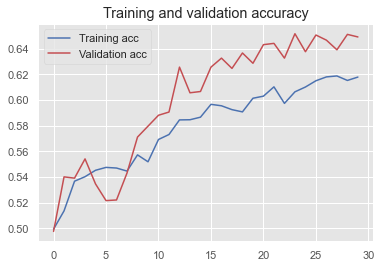

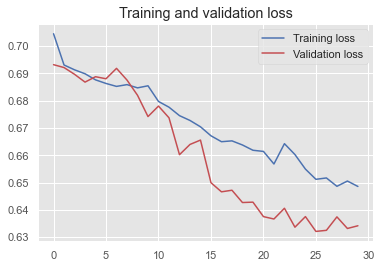

In [52]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import seaborn as sns
history = history


print(history.history)
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Matrice de confusion

In [53]:
Y_pred = history.model.predict(X_valid)


In [54]:
Y_pred = np.argmax(Y_pred, axis=1)

In [63]:
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_pred, y_test)

    categories  = ['Negative','Positive']

    group_names = ['True Neg','False Neg', 'False Pos','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    true_neg = round((cf_matrix[0][0])*100 / (cf_matrix[0][0]+cf_matrix[1][0]),2)
    false_pos = round(100 - true_neg,2)
    false_neg = round((cf_matrix[0][1])*100 / (cf_matrix[0][1]+cf_matrix[1][1]),2)
    tru_pos = round(100 - false_neg,2)

    label_v2 =[f'True Neg {true_neg}% classe réel',f'False Neg {false_neg}% classe réel', f'False Pos {false_pos}% classe réel',f'True Pos {tru_pos}% classe réel']

    group = [value for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}  {v2}' for v1, v2 in zip(group_names,group_percentages)]

    categories_y  = [f'Negative ',
                     f'Positive ']

    categories_x  = [f'Negative 100% ',

                     f'Positive 100%  ']
    labels = np.asarray(labels).reshape(2,2)
    label_v2 = np.asarray(label_v2).reshape(2,2)
    print("Nouveau label",label_v2)

    sns.heatmap(cf_matrix, annot = label_v2, cmap = 'Blues',fmt = '',
                xticklabels = categories_x, yticklabels = categories_y)

    plt.ylabel("Classe prédite", fontdict = {'size':14}, labelpad = 10)
    plt.xlabel("Classe réelle"   , fontdict = {'size':14}, labelpad = 10)
    plt.title (f"Matrice de confusion n:{len(y_pred)}", fontdict = {'size':18}, pad = 20)

Nouveau label [['True Neg 71.08% classe réel' 'False Neg 41.06% classe réel']
 ['False Pos 28.92% classe réel' 'True Pos 58.94% classe réel']]


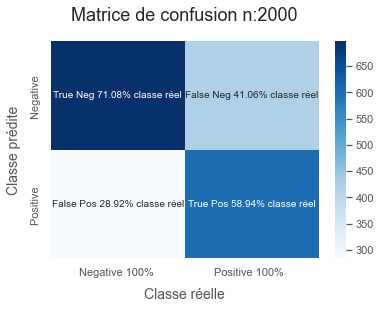

In [64]:
ConfusionMatrix(Y_pred, Y_valid)

* Rapport de la classification

In [57]:
print("Modèle LSTM report: \n\n",
      classification_report(Y_valid, Y_pred))








Modèle LSTM report: 

               precision    recall  f1-score   support

           0       0.63      0.71      0.67       982
           1       0.68      0.59      0.63      1018

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



In [58]:
Y_pred = history.model.predict(X_valid)

In [59]:
len(Y_pred)
print(len(Y_pred) , " ",len(Y_valid))


2000   2000


In [60]:
Y_pred = np.argmax(Y_pred, axis=1)
report = classification_report(Y_valid, Y_pred, output_dict=True)

In [61]:



df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.625448,0.710794,0.665396,982.000
1,0.678733,0.589391,0.630915,1018.000
accuracy,0.649000,0.649000,0.649000,0.649
macro avg,0.652091,0.650093,0.648155,2000.000
weighted avg,0.652570,0.649000,0.647845,2000.000


In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_valid, Y_pred)

#0.564



0.649